# Dataset Analysis for the Report

In [1]:
import os
import json
import typing
from tqdm import tqdm

Data path

In [2]:
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_DIR = os.path.join(PROJECT_DIR, 'data', 'podcasts-transcript', 'spotify-podcasts-2020')

# A text file containing the list of all files
JSON_FILE_LIST = os.path.join(DATA_DIR, "json_file_list.txt")
JSON_FILE_LIST

'/home/erik/Projects/KTH/dd2476-podcast-search/data/podcasts-transcript/spotify-podcasts-2020/json_file_list.txt'

In [3]:
def load_episode_token_list(fpath: str) -> typing.Any:
    with open(fpath, 'r') as f:
        data = json.load(f)
    
    last_result = data['results'][-1]
    alternative = last_result['alternatives'][0]
    if (len(alternative.keys()) != 1):
        print("Potentially wrong data: ", fpath)
        return []
    
    return alternative['words']

Read the list of json files

In [4]:
json_files = []
with open(JSON_FILE_LIST, "r") as f:
    for line in f:
        json_files.append(line.strip())

## 1. How many words are there in each json file?

Use multiprocessing to answer this question

In [5]:
import multiprocessing as mp
mp.cpu_count()

16

Helper function, partition a list to evenly-sized chunk (if possible)

In [6]:
def partition(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

chunk_size = len(json_files) // mp.cpu_count()
chunk_size

6585

In [7]:
def process_partition(partition, index):
    print(f"Processing partition: {index}, length = {len(partition)}")
    
    episode_words_map = dict()

    for idx, json_f in enumerate(partition):
        fpath = os.path.join(DATA_DIR, 'podcasts-transcripts', json_f)
        arr = load_episode_token_list(fpath)
        episode_id = json_f.split("/")[-1].replace(".json", "")
        
        word_count = len(arr)
        start_time = float(arr[0]['startTime'].replace('s', ''))
        end_time = float(arr[-1]['endTime'].replace('s', ''))

        episode_words_map[episode_id] = (word_count, start_time, end_time)
        if idx % 1000 == 0 or idx == len(partition) - 1:
            print(f"Process {index}, done {idx} items")
    
    with open(f"episode_words_map_{index}.csv", "w") as f:
        f.write("episode_id,word_count,start_time,end_time\n")
        
        for key, value in episode_words_map.items():
            f.write(f"{key},{value[0]},{value[1]},{value[2]}\n")
    
    print(f"Process {index} done!")

In [8]:
with mp.Pool(processes=mp.cpu_count()) as pool:
    partitions = partition(json_files, chunk_size)
    
    pool.starmap(process_partition, [(part, index) for index, part in enumerate(partitions)])

Processing partition: 0, length = 6585
Processing partition: 1, length = 6585
Processing partition: 4, length = 6585
Processing partition: 5, length = 6585
Processing partition: 6, length = 6585
Processing partition: 7, length = 6585
Process 0, done 0 itemsProcessing partition: 8, length = 6585
Process 4, done 0 items

Processing partition: 9, length = 6585
Process 1, done 0 itemsProcessing partition: 10, length = 6585
Process 7, done 0 items

Processing partition: 11, length = 6585Processing partition: 12, length = 6585

Processing partition: 13, length = 6585Process 9, done 0 items
Processing partition: 14, length = 6585Process 5, done 0 items

Processing partition: 15, length = 6585Process 8, done 0 items
Process 12, done 0 items

Process 6, done 0 items

Process 13, done 0 items
Process 11, done 0 items
Process 10, done 0 items
Processing partition: 2, length = 6585Processing partition: 3, length = 6585

Process 2, done 0 items
Process 15, done 0 items
Process 14, done 0 itemsProce

**Read the CSV episode word map to Pandas DF for further manipulation**

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
frames = []

for i in range(mp.cpu_count()):
    frames.append(pd.read_csv(f"./episode_words_map_{i}.csv"))

df = pd.concat(frames)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105360 entries, 0 to 6584
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   episode_id  105360 non-null  object 
 1   word_count  105360 non-null  int64  
 2   start_time  105360 non-null  float64
 3   end_time    105360 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 4.0+ MB


**Plot history gram of word count for episodes**

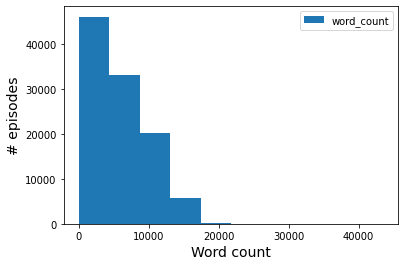

In [44]:
plot_df = df[['word_count']]

fig, ax = plt.subplots(figsize=(6, 4))
plot_df.plot.hist(bins=10, ax=ax)
plt.xlabel("Word count", fontsize=14)
plt.ylabel("# episodes", fontsize=14)

plt.savefig("plots/episode_word_count_hist.png", bbox_inches='tight')
plt.savefig("plots/episode_word_count_hist.pdf", bbox_inches='tight')

## 2. Episode count for each show

In [30]:
show_df = pd.read_csv("./show_episodes_count.csv")
show_df.head(5)

,show_id,episode_count
0,7mOT2t2HCmrwCo0822O8jT,1
1,4cdiD52hpZ975IKORnJoJV,4
2,7L2sAntb2QMfr3A4HmXOC1,1
3,1g77SuS39B6NoIwKCndTWY,1
4,6hRvE4B5zwZE2mkHp8JMrT,19


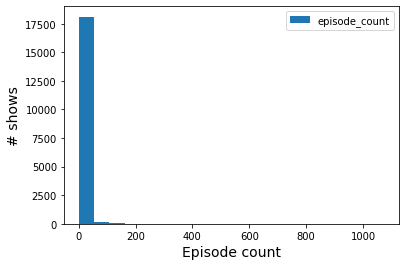

In [46]:
plot_df = show_df[['episode_count']]

fig, ax = plt.subplots(figsize=(6, 4))
plot_df.plot.hist(bins=20, ax=ax)
plt.xlabel("Episode count", fontsize=14)
plt.ylabel("# shows", fontsize=14)

plt.savefig("plots/show_episodes_count_hist.png", bbox_inches='tight')
plt.savefig("plots/show_episodes_count_hist.pdf", bbox_inches='tight')

## 3. Episode duration

In [35]:
episode_df = pd.read_csv('./episode_duration.csv')
episode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105357 entries, 0 to 105356
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        105357 non-null  object 
 1   duration  105357 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.6+ MB


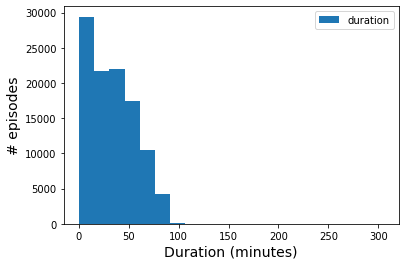

In [47]:
plot_df = episode_df[['duration']]

fig, ax = plt.subplots(figsize=(6, 4))
plot_df.plot.hist(bins=20, ax=ax)
plt.xlabel("Duration (minutes)", fontsize=14)
plt.ylabel("# episodes", fontsize=14)

plt.savefig("plots/episode_duration_hist.png", bbox_inches='tight')
plt.savefig("plots/episode_duration_hist.pdf", bbox_inches='tight')